## Analysis of trained SAEs

In [1]:
#load packages

import math, time
import torch
import os
import sys
sys.path.append('../..')
from functions.get_data import data_n_loaders
import matplotlib.pyplot as plt

In [ ]:
#SET THE PATH OF DATA and name of dataset
DATA_PATH = './data/' #change this to your data path
dataset = f'128dgaussian_intrinsicdim'

In [ ]:
#choose models to visualize

#get exptnames from folder names within saved_models
exptnames = []
for root, dirs, files in os.walk('saved_models'):
    for dir in dirs:
        if 'checkpoints_' in dir:
            exptnames.append(dir.split('checkpoints_')[1])

#sort exptnames to have all with same sae_type (name after the first _ within exptnames) together; after saename, the float following must be used for sorting
order = {'relu': 0, 'jumprelu': 1, 'topk': 2, 'spade': 3}
exptnames = sorted(exptnames, key=lambda x: (order[x.split('_')[1]]))

#get parameters from experiment names
saetypes = []
for exptname in exptnames:
    if 'spade' in exptname:
        saetypes.append('sparsemax_dist')
    elif 'topk_relu' in exptname:
        saetypes.append('topk_relu')
    else:
        saetypes.append(exptname.split('_')[1])
max_epochs = []
for exptname in exptnames:
    epochs = []
    for root, dirs, files in os.walk('saved_models/checkpoints_'+exptname):
        for file in files:
            if 'model_' in file:
                epochs.append(int(file.split('_')[1].split('.pt')[0].split('epochs')[0]))
    max_epochs.append(max(epochs))
kvals_all = torch.zeros((len(exptnames),), dtype=int)
for i in range(len(exptnames)):
    if saetypes[i] == 'topk_relu':
        kvals_all[i] = int(exptnames[i].split('_k')[1].split('_')[0])
    else:
        kvals_all[i] = 0
kvals_all = kvals_all.tolist()
gammavals_all = []
for i in range(len(exptnames)):
    if saetypes[i] == 'topk_relu':
        gammavals_all.append(0.0)
    else:
        gamma = float(exptnames[i].split('_gamreg')[1].split('_')[0])
        gammavals_all.append(gamma)

# choose which models (hyperparams) to plot
gammavals_relu = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
gammavals_jumprelu = [0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 1.0]
gammavals_spade = [0.001, 0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
kvals_topk = [4, 8, 16, 32, 64, 128, 256]
indices_relux = [i for i in range(len(exptnames)) if saetypes[i] == 'relu' and gammavals_all[i] in gammavals_relu]
indices_jumprelux = [i for i in range(len(exptnames)) if saetypes[i] == 'jumprelu' and gammavals_all[i] in gammavals_jumprelu]
indices_topkx = [i for i in range(len(exptnames)) if saetypes[i] == 'topk_relu' and kvals_all[i] in kvals_topk]
indices_spadex = [i for i in range(len(exptnames)) if saetypes[i] == 'sparsemax_dist' and gammavals_all[i] in gammavals_spade]
indices_all = indices_relux + indices_jumprelux + indices_topkx + indices_spadex
exptnames = [exptnames[i] for i in indices_all]
max_epochs = [max_epochs[indices_all[i]] for i in range(len(indices_all))]
saetypes = [saetypes[i] for i in indices_all]
kvals_all = [kvals_all[i] for i in indices_all]
gammavals_all = [gammavals_all[i] for i in indices_all]

In [ ]:
#load trained models for chosen hyperparams
from models import SAE
dim = 128 #of points in dataset
import numpy as np
device = 'cuda'
modelsall = []
width = 512 #standard in this expt set
for i in range(len(exptnames)):
    exptnamei = exptnames[i]
    normalize_decoder = False if saetypes[i] == 'sparsemax_dist' else True 
    modeli = SAE(dim, width, sae_type=saetypes[i],kval_topk=kvals_all[i], normalize_decoder=normalize_decoder)
    state_dict = torch.load(f"./saved_models/checkpoints_{exptnamei}/model_{max_epochs[i]}epochs.pt")
    modeli.load_state_dict(state_dict['model'])
    modelsall.append(modeli.to(device))

In [ ]:
#load data subset

# LAB_DIR = os.environ['USERDIR']
# DATA_PATH = LAB_DIR+'/data'

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#load entire train data and transform parameters
torch.manual_seed(0)
numpoints_perconcept = 1000
num_concepts = 5
batchsize = 2048
meannorm2_concepts_all = []
datavars_perconcept = torch.zeros((num_concepts,))
_,_,train_data, _ = data_n_loaders(dataset, batchsize, return_data=True, \
                                    data_path=DATA_PATH, standardise_data = True)

#sample equal number of points from each class
intrinsic_dims = train_data.truefeatures['intrinsic_dims']
data_subset_perconcept = []
labels_subset_perconcept = []
for j in range(num_concepts):
    indices = train_data.labels == j
    rand_indices_i = torch.randperm(indices.sum())[:numpoints_perconcept]
    data_subset_perconcept.append(train_data.data[indices][rand_indices_i])
    labels_subset_perconcept.append(train_data.labels[indices][rand_indices_i])
data_subset = torch.cat(data_subset_perconcept, dim=0)
labels_subset = torch.cat(labels_subset_perconcept, dim=0)
meannorm2_concepts = torch.stack([torch.mean(torch.norm(data_subset[labels_subset==j,:], dim=1)**2) for j in range(num_concepts)])
meannorm2_concepts_all.append(meannorm2_concepts)
for k in range(num_concepts):
    datavars_perconcept[k] = torch.var(data_subset[labels_subset==k,:], dim=0).sum()


In [ ]:
#get latent representations (sparse codes) on data subset
latent_reps_all = []
Cdatacos = []
stableranks = []
l0_perconcept_all = []
l0_all = []
mse_perconcept_all = torch.zeros((len(exptnames),num_concepts))
mse_all = torch.zeros((len(exptnames),))
nmse_all = torch.zeros((len(exptnames),))
mse_center = torch.zeros((len(exptnames), num_concepts))
for i in range(len(exptnames)):
    modeli = modelsall[i]
    with torch.no_grad():
        
        preds, latent_reps = modeli(data_subset.to(device), return_hidden=True)
        mse_persample = torch.sum((preds - data_subset.to(device))**2, dim=-1)
        mse_perconcept_all[i,:] = torch.stack([torch.mean(mse_persample[labels_subset==j]) for j in range(num_concepts)])
        mse_all[i] = torch.mean(mse_persample)
        
        #mse wrt mean of each concept
        for k in range(num_concepts):
            center_k = data_subset[labels_subset==k,:].mean(dim=0, keepdim=True).to(device)
            mse_center[i,k] = (preds[labels_subset==k,:]-center_k).pow(2).sum(dim=-1).mean()
            
        latentsflat = latent_reps.flatten()
        active = latentsflat>1e-12
        if active.sum()>0:
            # threshold = torch.quantile(latentsflat[active], 0.01)
            threshold = 1e-6
            activelatents = (latent_reps>threshold).float().sum(dim=1)
            # activelatentdist_all.append(activelatents)
            l0_perconcept = torch.stack([torch.mean(activelatents[labels_subset==j]) for j in range(num_concepts)])
            l0_perconcept_all.append(l0_perconcept)
            l0_all.append(torch.mean(activelatents))
        else:
            # activelatentdist_all.append(torch.zeros((latent_reps_all[i].shape[0],)))
            l0_perconcept_all.append(torch.zeros((num_concepts,)))
            l0_all.append(torch.tensor([0.0]))

        #sparse code correlations for data pairs
        latent_reps_all.append(latent_reps)
        Cdata = latent_reps @ latent_reps.T
        
        #sparse code correlations for latent pairs
        norms = torch.norm(latent_reps, dim=1).unsqueeze(1)
        Cdatacos.append(Cdata/(norms @ norms.T + 1e-12))

l0_perconcept_all = [l0.cpu().numpy() for l0 in l0_perconcept_all]
l0_perconcept_all = torch.tensor(l0_perconcept_all)

In [6]:
#sort latents acc to avg concept act, get latent-latent corrs

deadlatents_all = []
for i in range(len(exptnames)):
    if (latent_reps_all[i]>1e-12).sum()==0:
        deadlatents_all.append(torch.ones((latent_reps_all[i].shape[-1],), dtype=bool))
    else:
        threshold = torch.quantile(latent_reps_all[i][latent_reps_all[i]>0.0].flatten(), 0.1)
        # threshold = 1e-12
        deadlatents = torch.all(latent_reps_all[i] <= threshold, dim=0)
        deadlatents_all.append(deadlatents.cpu())

#identify concept which latent activates most for
classavg_reps = [torch.zeros(num_concepts, latent_reps_all[0].shape[-1]) for i in range(len(exptnames))]
for i in range(len(exptnames)):
    for c in range(num_concepts):
        classavg_reps[i][c] = torch.mean(latent_reps_all[i][labels_subset==c], dim=0)    
order_by_concept_all = []
concepts_of_latents_all = []
for i in range(len(exptnames)):
    concepts_of_latents = torch.argmax(classavg_reps[i][:, ~deadlatents_all[i]], dim=0) #gives indices of concepts with max value in each latent dimension
    order_by_concept = torch.argsort(concepts_of_latents) #sorts latents by concept
    order_by_concept_all.append(order_by_concept)
    concepts_of_latents_all.append(concepts_of_latents)


#sort latent representations by concept
latentreps_conceptsorted_all = []
for i in range(len(exptnames)):
    activelatents = ~deadlatents_all[i]
    latentsactive = latent_reps_all[i][:, activelatents]
    latentsactive_conceptsorted = latentsactive[:, order_by_concept_all[i]]
    latentsdead = latent_reps_all[i][:, ~activelatents]
    latents_sortedanddead = torch.cat([latentsactive_conceptsorted, latentsdead], dim=1)
    latentreps_conceptsorted_all.append(latents_sortedanddead) #reorder latents by concepts


#track co-occurrence of latents
Clatent = []
for i in range(len(exptnames)):
    Clatent.append(latentreps_conceptsorted_all[i].T @ latentreps_conceptsorted_all[i])

Clatent_cos = []
Clatent_cos_active = []
for i in range(len(exptnames)):
    norms = torch.norm(latentreps_conceptsorted_all[i], dim=0).unsqueeze(1)
    active_i = (norms>1e-12).squeeze()
    eps = 1e-6
    C = Clatent[i]/(eps+ (norms @ norms.T))
    Clatent_cos.append(C)
    C  = C[active_i,:]
    C = C[:, active_i]
    Clatent_cos_active.append(C)

In [ ]:
#group by sae_type
indices_spade = [i for i in range(len(exptnames)) if saetypes[i] == 'sparsemax_dist']
indices_topk = [i for i in range(len(exptnames)) if saetypes[i] == 'topk_relu']
indices_relu = [i for i in range(len(exptnames)) if saetypes[i] == 'relu']
indices_jumprelu = [i for i in range(len(exptnames)) if saetypes[i] == 'jumprelu']
indices_allsaes = [indices_relu, indices_jumprelu, indices_topk, indices_spade]

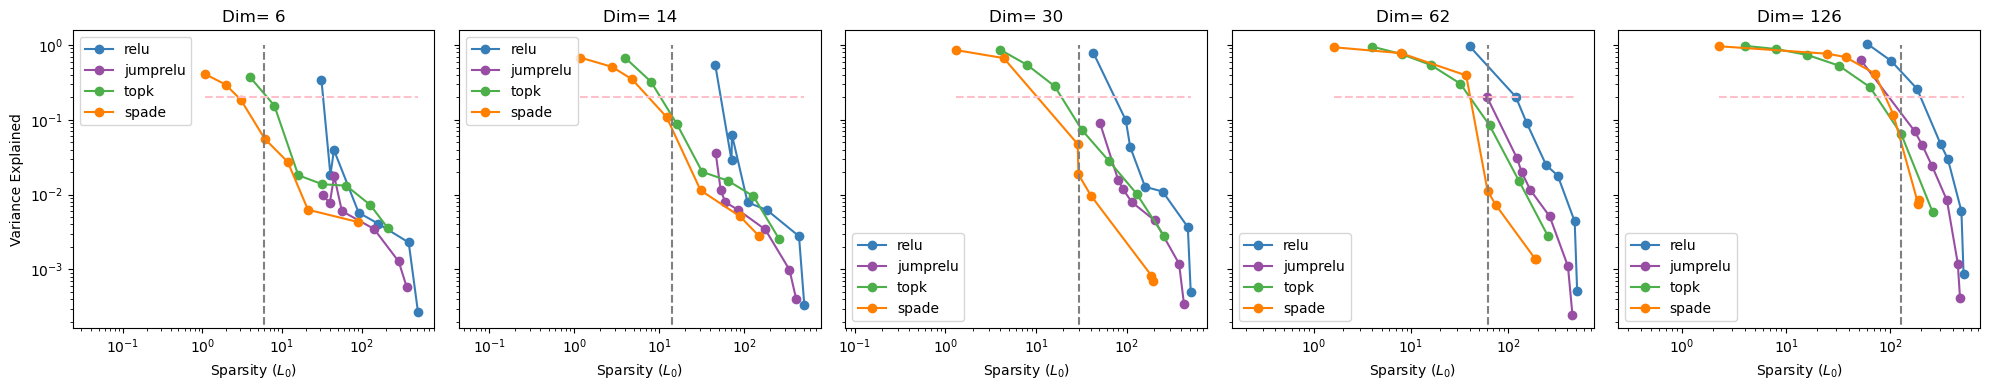

In [ ]:
#plot variance explained vs sparsity for each concept
saeorder = ['relu', 'jumprelu', 'topk_relu', 'sparsemax_dist']
colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}
fig, ax = plt.subplots(1, num_concepts, figsize=(4*num_concepts, 4), sharey=True)
for j in range(num_concepts):
    
    count = 0
    for ind in [indices_relu, indices_jumprelu, indices_topk, indices_spade]:
        l0vals = l0_perconcept_all[ind,j]
        l0vals_sorted, order = torch.sort(l0vals)
        label = saeorder[count]
        if label=='sparsemax_dist':
            label = 'spade'
        elif label=='topk_relu':
            label = 'topk'
        ax[j].plot(l0vals_sorted, (mse_perconcept_all[ind,j][order].cpu()/datavars_perconcept[j]), \
            c=colors_saetypes[saeorder[count]], alpha=1.0, marker='o', linestyle='solid', label=label)
        count+=1
    ax[j].set_yscale('log')
    ax[j].set_xscale('log')
    ax[j].legend()
    ax[j].set_xlabel(r'Sparsity ($L_0$)')
    if j==0:
        ax[j].set_ylabel(r'Variance Explained')
    ax[j].set_title("Dim= "+str(train_data.truefeatures['intrinsic_dims'][j].item()))
    ax[j].vlines(intrinsic_dims[j], 0, 1, linestyles='dashed', colors='gray')

    min_l0 = min([l0_perconcept_all[i][j].min().cpu() for i in range(len(exptnames))])
    max_l0 = max([l0_perconcept_all[i][j].max().cpu() for i in range(len(exptnames))])
    ax[j].hlines(1-0.8, min_l0, max_l0, colors='pink', linestyles='dashed')


fig.tight_layout()


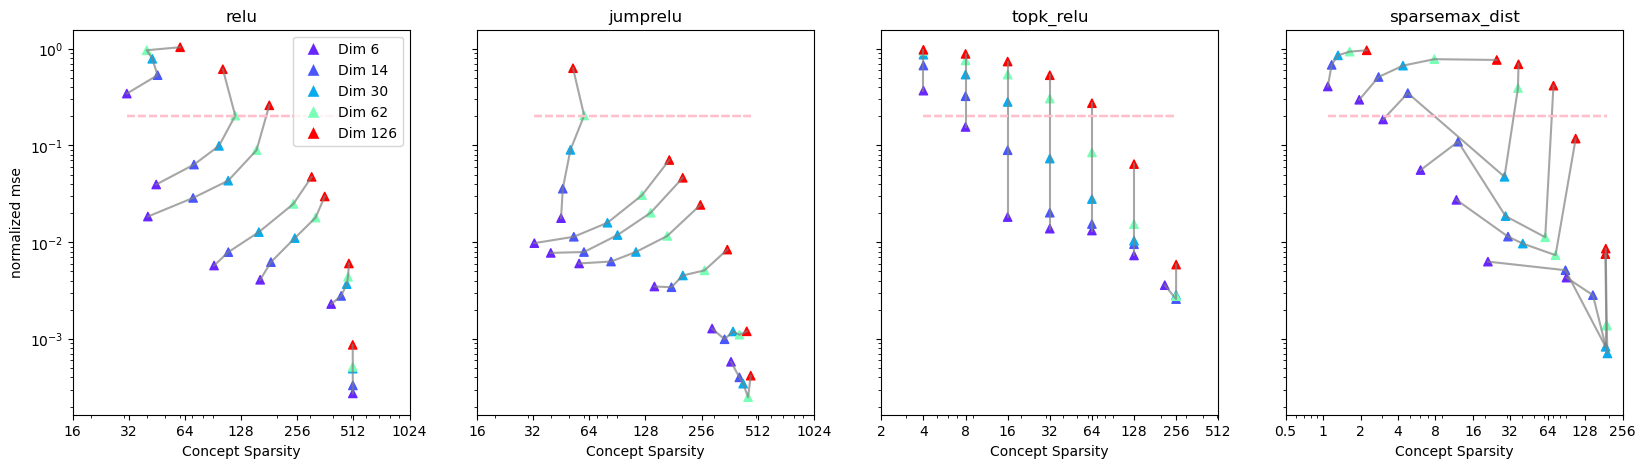

In [ ]:
#plot normalized mse vs sparsity for all concepts for each SAE type
colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}

cmap = plt.get_cmap('rainbow')
norm = plt.Normalize(vmin=0, vmax=1)
fig, ax = plt.subplots(1, len(set(saetypes)), figsize=(len(set(saetypes))*5, 5), sharey=True)
colors_conceptsx = [cmap(norm(intrinsic_dims[i]/max(intrinsic_dims))) for i in range(len(intrinsic_dims))]
for i in range(len(exptnames)):
    plotid = saeorder.index(saetypes[i])    
    # colors = colors_concepts
    colors = cmap(norm(intrinsic_dims/max(intrinsic_dims)))
    
    ax[plotid].plot(l0_perconcept_all[i,:], mse_perconcept_all[i, :]/datavars_perconcept, color='gray', linestyle='solid', alpha=0.7)
    # ax[plotid].plot(intrinsic_dims, intrinsic_dims, color='gray', linestyle='dashed', alpha=0.1)
    ax[plotid].scatter(l0_perconcept_all[i,:], mse_perconcept_all[i, :]/datavars_perconcept, \
        color=colors, marker='^', alpha=1.0)

    ax[plotid].set_xlabel(r'Concept Sparsity')
    if plotid==0:
        ax[plotid].set_ylabel(r'normalized mse')
        # Create custom legend only for the 5 colors_concepts and label them with their intrinsic dims
        handles = [plt.Line2D([0], [0], marker='^', color='w', markerfacecolor=colors_conceptsx[i], markersize=10) for i in range(num_concepts)]
        labels = [f'Dim {intrinsic_dims[i].item()}' for i in range(num_concepts)]
        ax[plotid].legend(handles, labels)
    # ax[plotid].set_ylabel(r'Sparsity $L_0$')
    # ax.set_yscale('log')
    
    # ax[plotid].set_xticks(ticks=intrinsic_dims, labels=intrinsic_dims.tolist())
    ax[plotid].hlines(1-0.8, l0_perconcept_all[indices_allsaes[plotid],:].min(), \
        l0_perconcept_all[indices_allsaes[plotid],:].max(),\
         colors='pink', linestyles='dashed')
    ax[plotid].set_yscale('log')
    ax[plotid].set_title(saetypes[i])
    # ax[plotid].set_xlim(min(intrinsic_dims).item()-1, max(intrinsic_dims).item()+5)

#for each axis, set xticks to be powers of 2 between its xmin and xmax
import numpy as np
import math

# Loop over each axis
for countax, axis in enumerate(ax):
    
    minx = l0_perconcept_all[indices_allsaes[countax],:].min() * 0.9
    maxx = l0_perconcept_all[indices_allsaes[countax],:].max() * 1.1
    
    axis.set_xlim(minx, maxx)
    axis.set_xscale('log')
    
    # Convert to scalars before applying log2
    min_pow = int(math.floor(math.log2(float(minx))))
    max_pow = int(math.ceil(math.log2(float(maxx))))
    
    # Generate powers of 2 within range
    xticks = [2**i for i in range(min_pow, max_pow + 1)]
    
    # Set xticks explicitly
    axis.set_xticks(xticks)
    axis.set_xticklabels([2**i for i in range(min_pow, max_pow + 1)])  # LaTeX-style labels

plt.show()


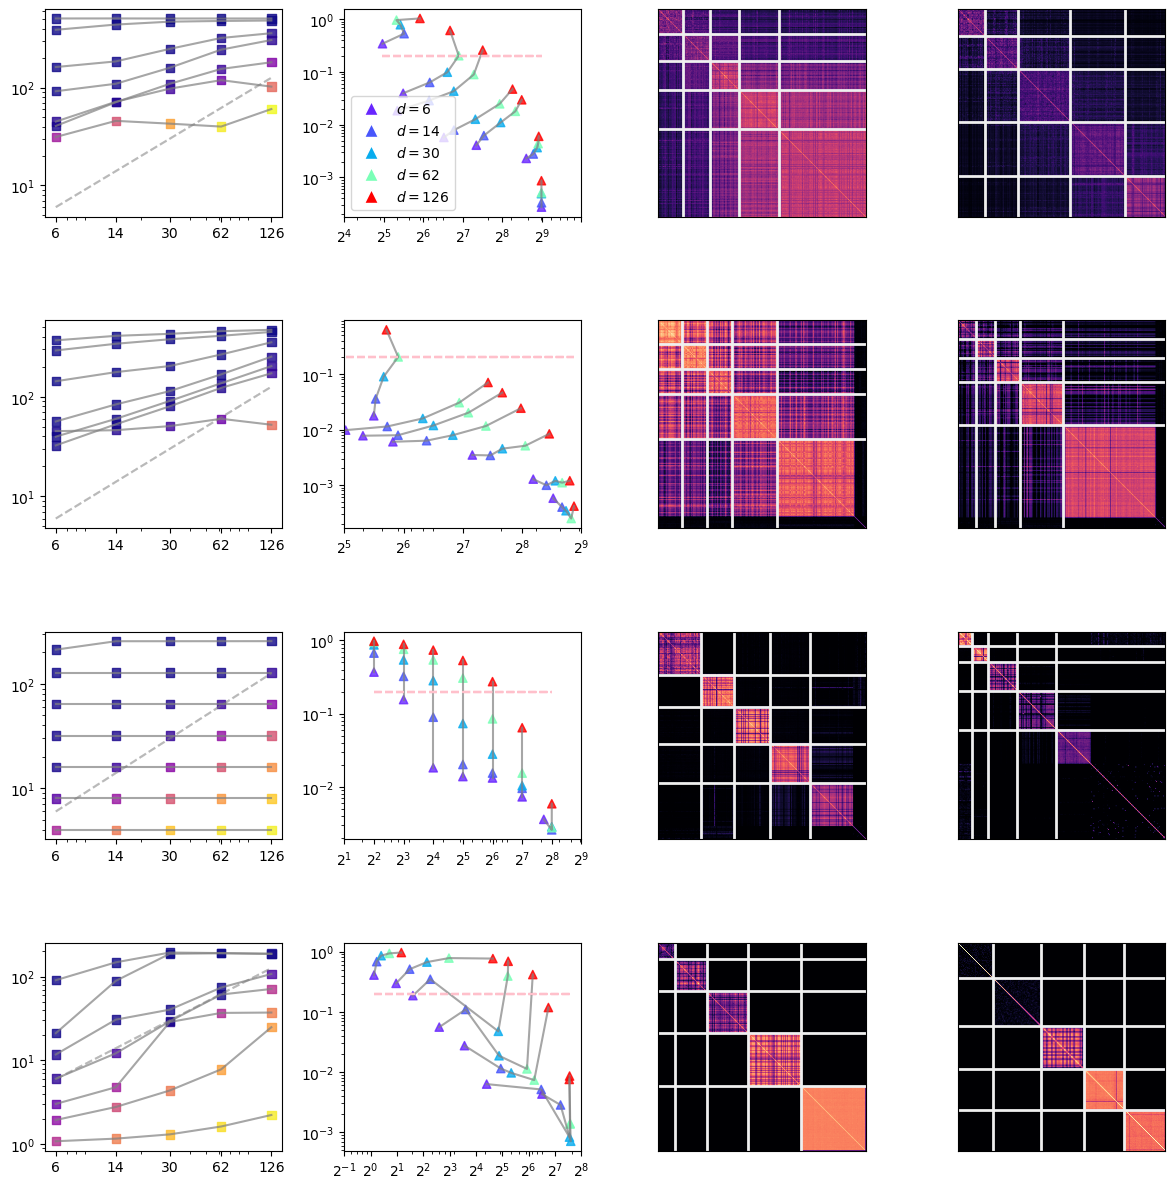

In [10]:
import matplotlib.patches as patches

colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}

cmap = plt.get_cmap('rainbow')
norm = plt.Normalize(vmin=0, vmax=1)
fig, axes = plt.subplots(len(set(saetypes)), 4, figsize=(4*3, 3*len(set(saetypes))))

ax = axes[:,1]
colors_conceptsx = [cmap(norm(intrinsic_dims[i]/max(intrinsic_dims))) for i in range(len(intrinsic_dims))]
for i in range(len(exptnames)):
    plotid = saeorder.index(saetypes[i])    
    # colors = colors_concepts
    colors = cmap(norm(intrinsic_dims/max(intrinsic_dims)))
    
    ax[plotid].plot(l0_perconcept_all[i,:], mse_perconcept_all[i, :]/datavars_perconcept, color='gray', linestyle='solid', alpha=0.7)
    # ax[plotid].plot(intrinsic_dims, intrinsic_dims, color='gray', linestyle='dashed', alpha=0.1)
    ax[plotid].scatter(l0_perconcept_all[i,:], mse_perconcept_all[i, :]/datavars_perconcept, \
        color=colors, marker='^', alpha=0.8)

    # ax[plotid].set_xlabel(r'Concept $L_0$')
    if plotid==0:
        # ax[plotid].set_ylabel(r'normalized mse')
        # Create custom legend only for the 5 colors_concepts and label them with their intrinsic dims
        handles = [plt.Line2D([0], [0], marker='^', color='w', markerfacecolor=colors_conceptsx[i], markersize=10) for i in range(num_concepts)]
        labels = [f'$d=${intrinsic_dims[i].item()}' for i in range(num_concepts)]
        ax[plotid].legend(handles, labels)
    # ax[plotid].set_ylabel(r'Sparsity $L_0$')
    # ax.set_yscale('log')
    
    # ax[plotid].set_xticks(ticks=intrinsic_dims, labels=intrinsic_dims.tolist())
    ax[plotid].hlines(1-0.8, l0_perconcept_all[indices_allsaes[plotid],:].min(), \
        l0_perconcept_all[indices_allsaes[plotid],:].max(),\
         colors='pink', linestyles='dashed')
    ax[plotid].set_yscale('log')
    # ax[plotid].set_title(saetypes[i])
    # ax[plotid].set_xlim(min(intrinsic_dims).item()-1, max(intrinsic_dims).item()+5)

#for each axis, set xticks to be powers of 2 between its xmin and xmax
import numpy as np
import math

# Loop over each axis
for countax, axis in enumerate(ax):
    
    minx = l0_perconcept_all[indices_allsaes[countax],:].min() - 0.1
    maxx = l0_perconcept_all[indices_allsaes[countax],:].max() * 1.01
    
    axis.set_xlim(minx, maxx)
    axis.set_xscale('log')
    
    # Convert to scalars before applying log2
    min_pow = int(math.floor(math.log2(float(minx))))
    max_pow = int(math.ceil(math.log2(float(maxx))))
    
    # Generate powers of 2 within range
    xticks = [2**i for i in range(min_pow, max_pow + 1)]
    
    # Set xticks explicitly
    axis.set_xticks(xticks)
    # labelsz = [f"$2^{i}$" if i >= 0 else f"$2^{{-{abs(i)}}}$" for i in range(min_pow, max_pow + 1)]
    labelsz = [None] * (max_pow - min_pow + 1)
    for i in range(min_pow, max_pow+1):
        if i < 0:
            labelsz[i-min_pow] = f"$2^{{-{abs(i)}}}$"
        elif i>=10:
            labelsz[i-min_pow] = ''
        else:
            labelsz[i-min_pow] = f"$2^{i}$"
    axis.set_xticklabels(labelsz)

colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}


ax = axes[:,0]
cmap = plt.get_cmap('plasma')
norm = plt.Normalize(vmin=0, vmax=1)
for i in range(len(exptnames)):
    plotid = saeorder.index(saetypes[i])
    if saetypes[i] == 'sparsemax_dist':
        label = 'spade'
    elif saetypes[i] == 'topk_relu':
        label = 'topk'
    else:
        label = saetypes[i]
    # varex = mse_center[i, :].cpu() / datavars_perconcept
    varex = mse_perconcept_all[i, :].cpu() / datavars_perconcept
    colors = cmap(norm(varex))
    
    ax[plotid].plot(intrinsic_dims, l0_perconcept_all[i, :], color='gray', linestyle='solid', alpha=0.7)
    ax[plotid].plot(intrinsic_dims, intrinsic_dims, color='gray', linestyle='dashed', alpha=0.1)
    ax[plotid].scatter(intrinsic_dims, l0_perconcept_all[i, :], color=colors, marker='s', alpha=0.8)

    # ax[plotid].set_xlabel(f'Concept dim $d$')
    ax[plotid].set_xscale('log')
    ax[plotid].set_xticks(ticks=intrinsic_dims, labels=intrinsic_dims.tolist())
    
    ax[plotid].set_yscale('log')
    # ax[plotid].set_title(label)

ax = axes[:, 2:]
for i in range(len(exptnames)):
    if saetypes[i]!='topk_relu':
        if saetypes[i]=='relu':
            gammvals = gammavals_relu
        elif saetypes[i]=='jumprelu':
            gammvals = gammavals_jumprelu
        elif saetypes[i]=='sparsemax_dist':
            gammvals = gammavals_spade
        gami = float(exptnames[i].split('gamreg')[1].split('_')[0])
        loc = gammvals.index(gami)
    else:
        kvalues_order = [256, 128, 64, 32, 16, 8, 4]
        kval_i = int(exptnames[i].split('topk_relu_k')[1].split('_')[0])
        loc = kvalues_order.index(kval_i)
    concepts_now = concepts_of_latents_all[i][order_by_concept_all[i]]
    numlatents_perconc = [torch.sum(concepts_now==j).item() for j in range(num_concepts)]
    latentconcboundarylocs = []
    for jn in range(len(numlatents_perconc)):
        latentconcboundarylocs.append(sum(numlatents_perconc[:jn]))
    latentconclabellocs = [(latentconcboundarylocs[i]+latentconcboundarylocs[i+1])/2 for i in range(len(latentconcboundarylocs)-1)]
    if loc in [2, 4]:
        loc = [2,4].index(loc)
        rowid = saeorder.index(saetypes[i])
        height, width = Clatent_cos_active[i].shape
        ax[rowid, loc].imshow(Clatent_cos_active[i].cpu(), cmap='magma', vmin=0, vmax=1, extent=[0, width, height, 0])
        ax[rowid, loc].vlines(latentconcboundarylocs[1:], 0, Clatent_cos_active[i].shape[0], colors='#EFEFEF', linestyles='solid',linewidth=2)
        ax[rowid, loc].hlines(latentconcboundarylocs[1:], 0, Clatent_cos_active[i].shape[1], colors='#EFEFEF', linestyles='solid',linewidth=2)
        # if saetypes[i]=='topk_relu':
        #     ax[rowid, loc].set_title(f"k={kval_i}")
        # else:
        #     ax[rowid, loc].set_title(f"$\gamma$={gami}")
        # ax[rowid, loc].set_xticks([0, Clatent_cos_active[i].shape[0]])
        # ax[rowid, loc].set_yticks([0, Clatent_cos_active[i].shape[1]])
        ax[rowid, loc].set_xticks([])
        ax[rowid, loc].set_yticks([])

#add width between subplots

fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
# plt.savefig('./figs/intrinsicdimfig2.pdf', bbox_inches='tight', dpi=300)


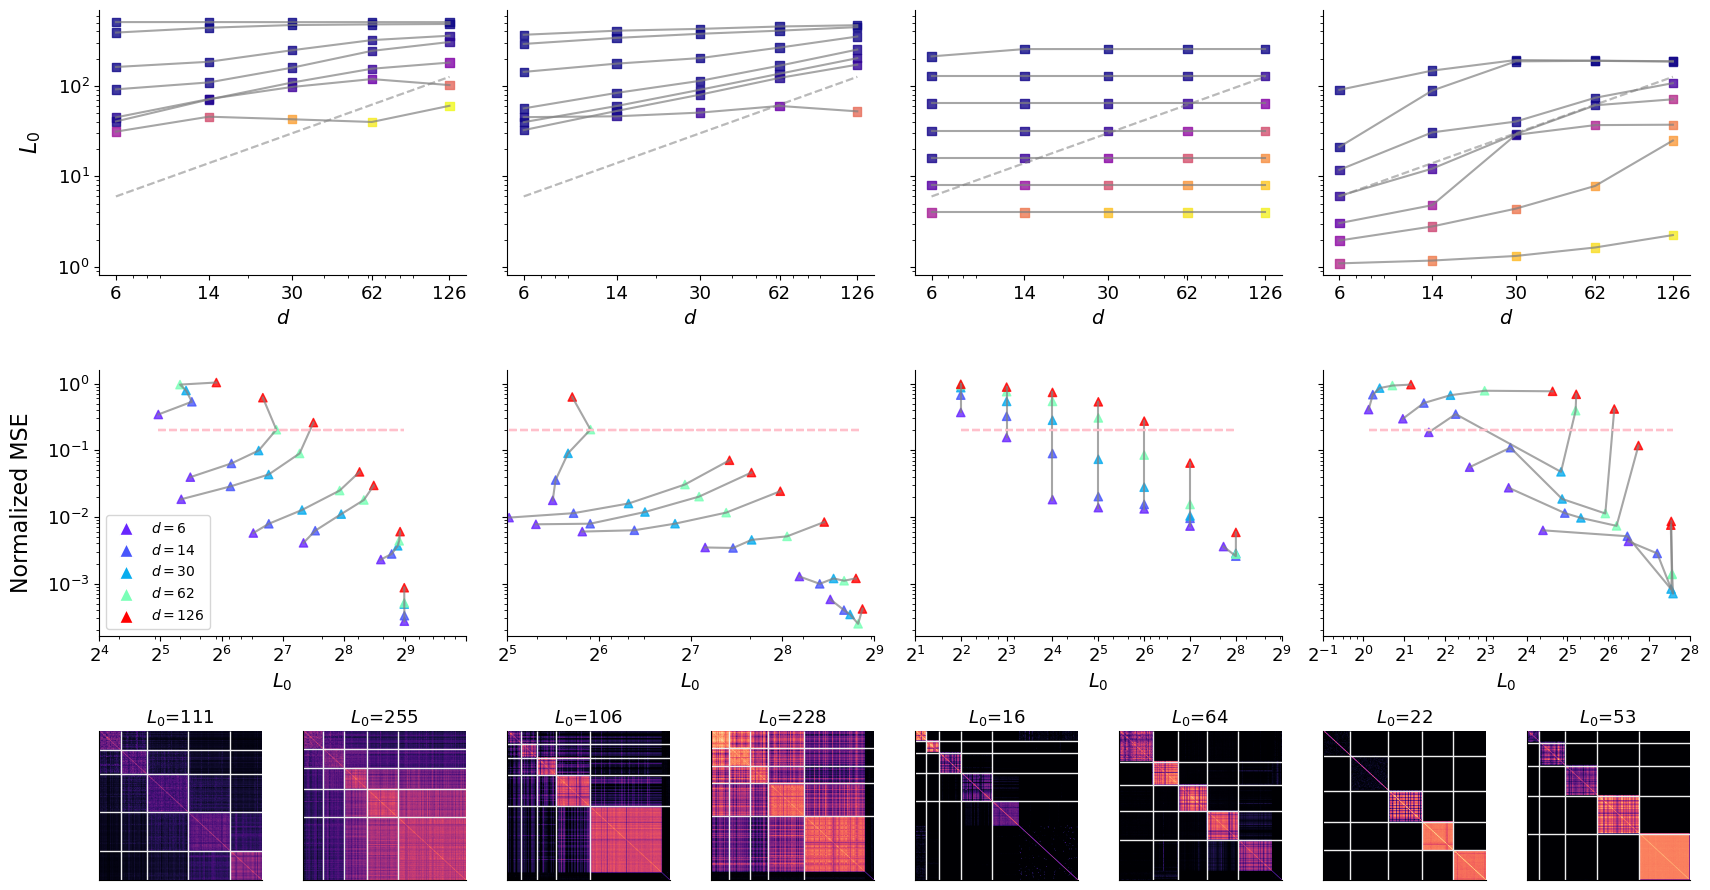

In [ ]:
#make main figure on heterogeneity
import matplotlib.patches as patches

colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}

cmap = plt.get_cmap('rainbow')
norm = plt.Normalize(vmin=0, vmax=1)
# fig, axes = plt.subplots(len(set(saetypes)), 4, figsize=(4*3, 3*len(set(saetypes))))
# scaleval = 3
# fig = plt.figure(figsize=(scaleval*8.2, scaleval*4.6))

# ax1 = plt.subplot2grid((5, 8), (0, 0), rowspan=2, colspan=2)
# ax2 = plt.subplot2grid((5, 8), (0, 2), rowspan=2, colspan=2)
# ax3 = plt.subplot2grid((5, 8), (0, 4), rowspan=2, colspan=2)
# ax4 = plt.subplot2grid((5, 8), (0, 6), rowspan=2, colspan=2)

# ax5 = plt.subplot2grid((5, 8), (2, 0), rowspan=2, colspan=2)
# ax6 = plt.subplot2grid((5, 8), (2, 2), rowspan=2, colspan=2)
# ax7 = plt.subplot2grid((5, 8), (2, 4), rowspan=2, colspan=2)
# ax8 = plt.subplot2grid((5, 8), (2, 6), rowspan=2, colspan=2)

# ax9 = plt.subplot2grid((5, 8), (4, 0), rowspan=1, colspan=1)
# ax10 = plt.subplot2grid((5, 8), (4, 1), rowspan=1, colspan=1)
# ax11 = plt.subplot2grid((5, 8), (4, 2), rowspan=1, colspan=1)
# ax12 = plt.subplot2grid((5, 8), (4, 3), rowspan=1, colspan=1)
# ax13 = plt.subplot2grid((5, 8), (4, 4), rowspan=1, colspan=1)
# ax14 = plt.subplot2grid((5, 8), (4, 5), rowspan=1, colspan=1)
# ax15 = plt.subplot2grid((5, 8), (4, 6), rowspan=1, colspan=1)
# ax16 = plt.subplot2grid((5, 8), (4, 7), rowspan=1, colspan=1)

import matplotlib.gridspec as gridspec

# Scaling factor for figure size
scaleval = 2  # Adjust this as needed
fig = plt.figure(figsize=(scaleval * 8.6, scaleval * 4.5))

# Define the GridSpec layout (5 rows, 8 columns)
gs = gridspec.GridSpec(5, 8, figure=fig, height_ratios=[0.8, 0.8, 0.8, 0.8, 1.4])

# Define subplots using GridSpec, mirroring the subplot2grid layout
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[0:2, 2:4], sharey=ax1)
ax3 = fig.add_subplot(gs[0:2, 4:6], sharey=ax1)
ax4 = fig.add_subplot(gs[0:2, 6:8], sharey=ax1)

ax5 = fig.add_subplot(gs[2:4, 0:2])
ax6 = fig.add_subplot(gs[2:4, 2:4], sharey=ax5)
ax7 = fig.add_subplot(gs[2:4, 4:6], sharey=ax5)
ax8 = fig.add_subplot(gs[2:4, 6:8], sharey=ax5)

ax9 = fig.add_subplot(gs[4, 0])
ax10 = fig.add_subplot(gs[4, 1])
ax11 = fig.add_subplot(gs[4, 2])
ax12 = fig.add_subplot(gs[4, 3])
ax13 = fig.add_subplot(gs[4, 4])
ax14 = fig.add_subplot(gs[4, 5])
ax15 = fig.add_subplot(gs[4, 6])
ax16 = fig.add_subplot(gs[4, 7])

axes = np.array([[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, ax11, ax13, ax15], [ax10, ax12, ax14, ax16]])
axes = axes.T

#plot normalized mse vs sparsity for all concepts for each SAE type
ax = axes[:,1]
colors_conceptsx = [cmap(norm(intrinsic_dims[i]/max(intrinsic_dims))) for i in range(len(intrinsic_dims))]
for i in range(len(exptnames)):
    plotid = saeorder.index(saetypes[i])    
    # colors = colors_concepts
    colors = cmap(norm(intrinsic_dims/max(intrinsic_dims)))
    
    ax[plotid].plot(l0_perconcept_all[i,:], mse_perconcept_all[i, :]/datavars_perconcept, color='gray', linestyle='solid', alpha=0.7)
    # ax[plotid].plot(intrinsic_dims, intrinsic_dims, color='gray', linestyle='dashed', alpha=0.1)
    ax[plotid].scatter(l0_perconcept_all[i,:], mse_perconcept_all[i, :]/datavars_perconcept, \
        color=colors, marker='^', alpha=0.8)
    ax[plotid].set_xlabel(r"$L_0$", fontsize=14)
    mseticks = [1e-3, 1e-2, 1e-1, 1e0]
    ax[plotid].set_yticks(mseticks, mseticks, fontsize=13)
    if plotid==0:
        ax[plotid].set_ylabel(r"Normalized MSE", fontsize=16, labelpad=10)

    # ax[plotid].set_xlabel(r'Concept $L_0$')
    if plotid==0:
        # ax[plotid].set_ylabel(r'normalized mse')
        # Create custom legend only for the 5 colors_concepts and label them with their intrinsic dims
        handles = [plt.Line2D([0], [0], marker='^', color='w', markerfacecolor=colors_conceptsx[i], markersize=10) for i in range(num_concepts)]
        labels = [f'$d=${intrinsic_dims[i].item()}' for i in range(num_concepts)]
        ax[plotid].legend(handles, labels)
    # ax[plotid].set_ylabel(r'Sparsity $L_0$')
    # ax.set_yscale('log')
    
    # ax[plotid].set_xticks(ticks=intrinsic_dims, labels=intrinsic_dims.tolist())
    ax[plotid].hlines(1-0.8, l0_perconcept_all[indices_allsaes[plotid],:].min(), \
        l0_perconcept_all[indices_allsaes[plotid],:].max(),\
         colors='pink', linestyles='dashed')
    ax[plotid].set_yscale('log')
    # ax[plotid].set_title(saetypes[i])
    # ax[plotid].set_xlim(min(intrinsic_dims).item()-1, max(intrinsic_dims).item()+5)

#for each axis, set xticks to be powers of 2 between its xmin and xmax
import numpy as np
import math

# Loop over each axis
for countax, axis in enumerate(ax):
    
    minx = l0_perconcept_all[indices_allsaes[countax],:].min() - 0.1
    maxx = l0_perconcept_all[indices_allsaes[countax],:].max() * 1.01
    
    axis.set_xlim(minx, maxx)
    axis.set_xscale('log')
    
    # Convert to scalars before applying log2
    min_pow = int(math.floor(math.log2(float(minx))))
    max_pow = int(math.ceil(math.log2(float(maxx))))
    
    # Generate powers of 2 within range
    xticks = [2**i for i in range(min_pow, max_pow + 1)]
    
    # Set xticks explicitly
    axis.set_xticks(xticks, labels=xticks, fontsize=13)
    # labelsz = [f"$2^{i}$" if i >= 0 else f"$2^{{-{abs(i)}}}$" for i in range(min_pow, max_pow + 1)]
    labelsz = [None] * (max_pow - min_pow + 1)
    for i in range(min_pow, max_pow+1):
        if i < 0:
            labelsz[i-min_pow] = f"$2^{{-{abs(i)}}}$"
        elif i>=10:
            labelsz[i-min_pow] = ''
        else:
            labelsz[i-min_pow] = f"$2^{i}$"
    axis.set_xticklabels(labelsz)
    

colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}

#plot sparsity vs intrinsic dimension of each concept
ax = axes[:,0]
cmap = plt.get_cmap('plasma')
norm = plt.Normalize(vmin=0, vmax=1)
for i in range(len(exptnames)):
    plotid = saeorder.index(saetypes[i])
    if saetypes[i] == 'sparsemax_dist':
        label = 'spade'
    elif saetypes[i] == 'topk_relu':
        label = 'topk'
    else:
        label = saetypes[i]
    # varex = mse_center[i, :].cpu() / datavars_perconcept
    varex = mse_perconcept_all[i, :].cpu() / datavars_perconcept
    colors = cmap(norm(varex))
    
    ax[plotid].plot(intrinsic_dims, l0_perconcept_all[i, :], color='gray', linestyle='solid', alpha=0.7)
    ax[plotid].plot(intrinsic_dims, intrinsic_dims, color='gray', linestyle='dashed', alpha=0.1)
    ax[plotid].scatter(intrinsic_dims, l0_perconcept_all[i, :], color=colors, marker='s', alpha=0.8)

    # ax[plotid].set_xlabel(f'Concept dim $d$')
    ax[plotid].set_xscale('log')
    ax[plotid].set_xticks(ticks=intrinsic_dims, labels=intrinsic_dims.tolist(), fontsize=13)
    l0ticks = [1e0, 1e1, 1e2]
    ax[plotid].set_yticks(l0ticks, l0ticks, fontsize=13)
    ax[plotid].set_xlabel(r"$d$", fontsize=14)
    if plotid==0:
        ax[plotid].set_ylabel(r"$L_0$", fontsize=16, labelpad=10)
    
    ax[plotid].set_yscale('log')
    
    # ax[plotid].set_title(label)

#plot latent-latent correlations for active latents
ax = axes[:, 2:]
for i in range(len(exptnames)):
    if saetypes[i]!='topk_relu':
        if saetypes[i]=='relu':
            gammvals = gammavals_relu
        elif saetypes[i]=='jumprelu':
            gammvals = gammavals_jumprelu
        elif saetypes[i]=='sparsemax_dist':
            gammvals = gammavals_spade
        gami = float(exptnames[i].split('gamreg')[1].split('_')[0])
        loc = gammvals.index(gami)
    else:
        kvalues_order = [256, 128, 64, 32, 16, 8, 4]
        kval_i = int(exptnames[i].split('topk_relu_k')[1].split('_')[0])
        loc = kvalues_order.index(kval_i)
    concepts_now = concepts_of_latents_all[i][order_by_concept_all[i]]
    numlatents_perconc = [torch.sum(concepts_now==j).item() for j in range(num_concepts)]
    latentconcboundarylocs = []
    for jn in range(len(numlatents_perconc)):
        latentconcboundarylocs.append(sum(numlatents_perconc[:jn]))
    latentconclabellocs = [(latentconcboundarylocs[i]+latentconcboundarylocs[i+1])/2 for i in range(len(latentconcboundarylocs)-1)]
    if loc in [2, 4]:
        loc = [4, 2].index(loc)
        rowid = saeorder.index(saetypes[i])
        height, width = Clatent_cos_active[i].shape
        ax[rowid, loc].imshow(Clatent_cos_active[i].cpu(), cmap='magma', vmin=0, vmax=1, extent=[0, width, height, 0])
        ax[rowid, loc].vlines(latentconcboundarylocs[1:], 0, Clatent_cos_active[i].shape[0], colors='#EFEFEF', linestyles='solid',linewidth=1)
        ax[rowid, loc].hlines(latentconcboundarylocs[1:], 0, Clatent_cos_active[i].shape[1], colors='#EFEFEF', linestyles='solid',linewidth=1)
        ax[rowid, loc].set_title(f"$L_0$={l0_all[i].item():.0f}", fontsize=13)
        # if saetypes[i]=='topk_relu':
        #     ax[rowid, loc].set_title(f"k={kval_i}")
        # else:
        #     ax[rowid, loc].set_title(f"$\gamma$={gami}")
        # ax[rowid, loc].set_xticks([0, Clatent_cos_active[i].shape[0]])
        # ax[rowid, loc].set_yticks([0, Clatent_cos_active[i].shape[1]])
        ax[rowid, loc].set_xticks([])
        ax[rowid, loc].set_yticks([])

#add width between subplots
for axx in axes.flatten():
    axx.set_aspect('auto')
    axx.spines['right'].set_visible(False)
    axx.spines['top'].set_visible(False)

for ax in [ax2, ax3, ax4, ax6, ax7, ax8]:
    ax.tick_params(labelleft=False)

plt.tight_layout()
# fig.subplots_adjust(hspace=0.5)
# plt.savefig('./figs/hetero_mainfigX.pdf', bbox_inches='tight', dpi=300)


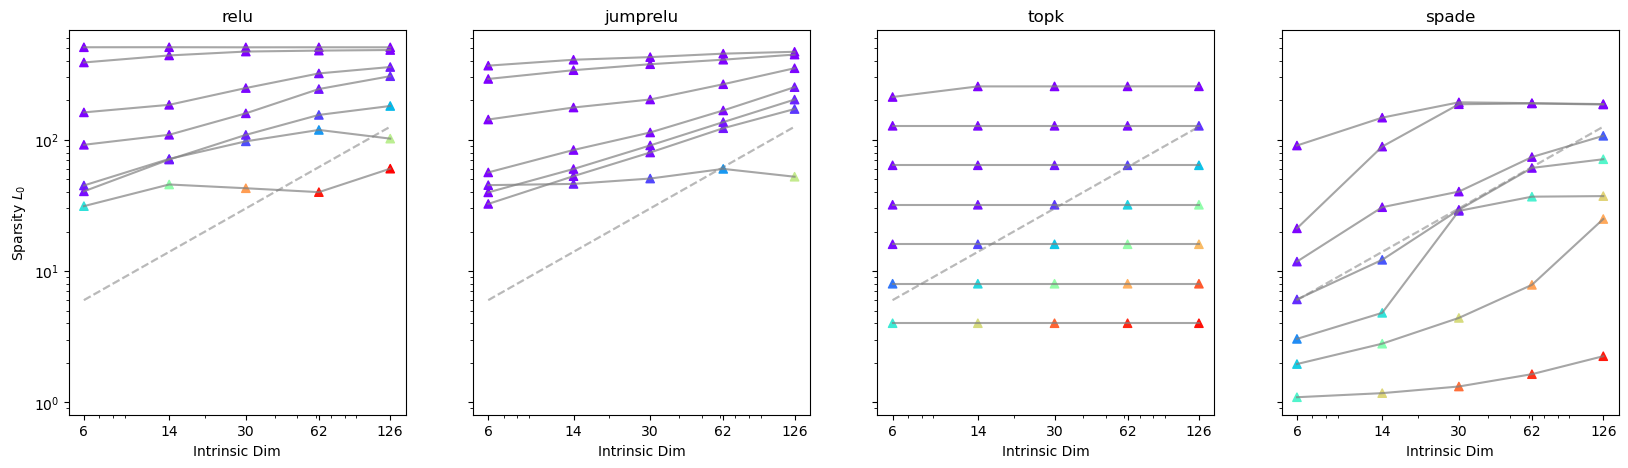

In [ ]:
#plot sparsity vs intrinsic dimension for each SAE type
colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}

cmap = plt.get_cmap('rainbow')
norm = plt.Normalize(vmin=0, vmax=1)
fig, ax = plt.subplots(1, len(set(saetypes)), figsize=(len(set(saetypes))*5, 5), sharey=True)

for i in range(len(exptnames)):
    plotid = saeorder.index(saetypes[i])
    if saetypes[i] == 'sparsemax_dist':
        label = 'spade'
    elif saetypes[i] == 'topk_relu':
        label = 'topk'
    else:
        label = saetypes[i]
    # varex = mse_center[i, :].cpu() / datavars_perconcept
    varex = mse_perconcept_all[i, :].cpu() / datavars_perconcept
    colors = cmap(norm(varex))
    
    ax[plotid].plot(intrinsic_dims, l0_perconcept_all[i, :], color='gray', linestyle='solid', alpha=0.7)
    ax[plotid].plot(intrinsic_dims, intrinsic_dims, color='gray', linestyle='dashed', alpha=0.1)
    ax[plotid].scatter(intrinsic_dims, l0_perconcept_all[i, :], color=colors, marker='^', alpha=1.0)

    ax[plotid].set_xlabel(r'Intrinsic Dim')
    if plotid==0:
        ax[plotid].set_ylabel(r'Sparsity $L_0$')
    # ax[plotid].set_ylabel(r'Sparsity $L_0$')
    # ax.set_yscale('log')
    ax[plotid].set_xscale('log')
    ax[plotid].set_xticks(ticks=intrinsic_dims, labels=intrinsic_dims.tolist())
    
    ax[plotid].set_yscale('log')
    ax[plotid].set_title(label)
plt.show()

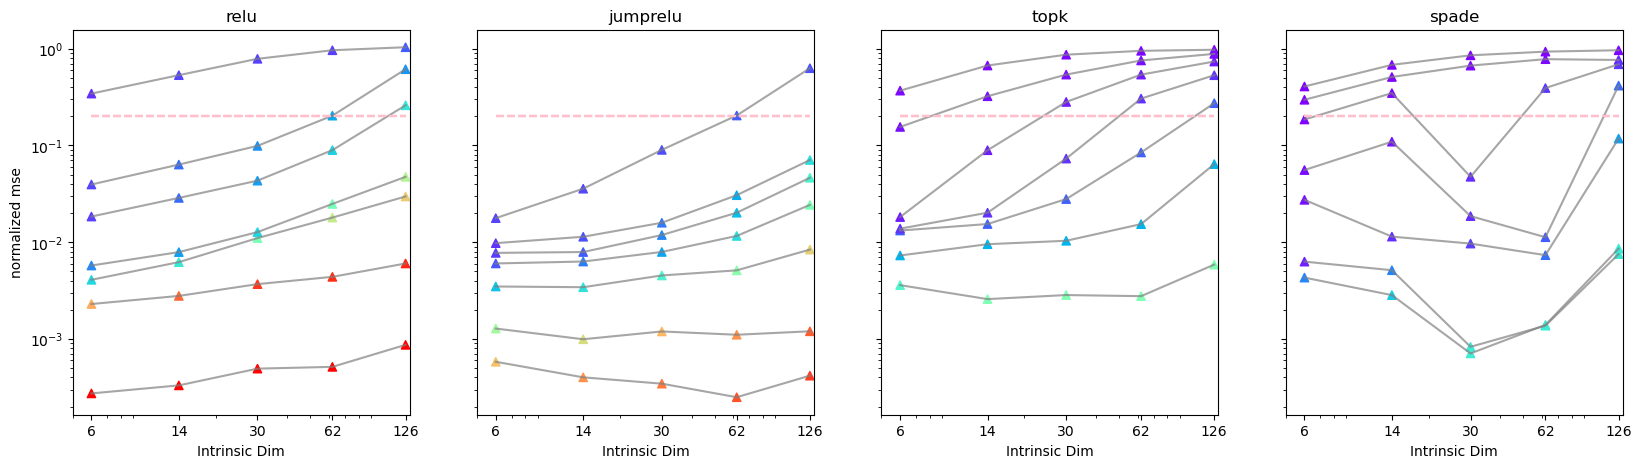

In [ ]:
#plot normalized mse vs intrinsic dimension of concepts for each SAE type
colors_saetypes = {'relu': '#377eb8', 'jumprelu':'#984ea3' , 'topk_relu': '#4daf4a', 'sparsemax_dist': '#ff7f00'}

cmap = plt.get_cmap('rainbow')
norm = plt.Normalize(vmin=0, vmax=1)
fig, ax = plt.subplots(1, len(set(saetypes)), figsize=(len(set(saetypes))*5, 5), sharey=True)

for i in range(len(exptnames)):
    plotid = saeorder.index(saetypes[i])
    if saetypes[i] == 'sparsemax_dist':
        label = 'spade'
    elif saetypes[i] == 'topk_relu':
        label = 'topk'
    else:
        label = saetypes[i]
    # varex = mse_center[i, :].cpu() / datavars_perconcept
    # varex = mse_perconcept_all[i, :].cpu() / datavars_perconcept
    varex = l0_perconcept_all[i,:]/l0_perconcept_all.max()
    colors = cmap(norm(varex))
    
    ax[plotid].plot(intrinsic_dims, mse_perconcept_all[i, :]/datavars_perconcept, color='gray', linestyle='solid', alpha=0.7)
    # ax[plotid].plot(intrinsic_dims, intrinsic_dims, color='gray', linestyle='dashed', alpha=0.1)
    ax[plotid].scatter(intrinsic_dims, mse_perconcept_all[i, :]/datavars_perconcept, color=colors, marker='^', alpha=1.0)

    ax[plotid].set_xlabel(r'Intrinsic Dim')
    if plotid==0:
        ax[plotid].set_ylabel(r'normalized mse')
    # ax[plotid].set_ylabel(r'Sparsity $L_0$')
    # ax.set_yscale('log')
    ax[plotid].set_xscale('log')
    ax[plotid].set_xticks(ticks=intrinsic_dims, labels=intrinsic_dims.tolist())
    ax[plotid].hlines(1-0.8, min(intrinsic_dims).item(), max(intrinsic_dims).item(),\
         colors='pink', linestyles='dashed')
    ax[plotid].set_yscale('log')
    ax[plotid].set_title(label)
    ax[plotid].set_xlim(min(intrinsic_dims).item()-1, max(intrinsic_dims).item()+5)
plt.show()

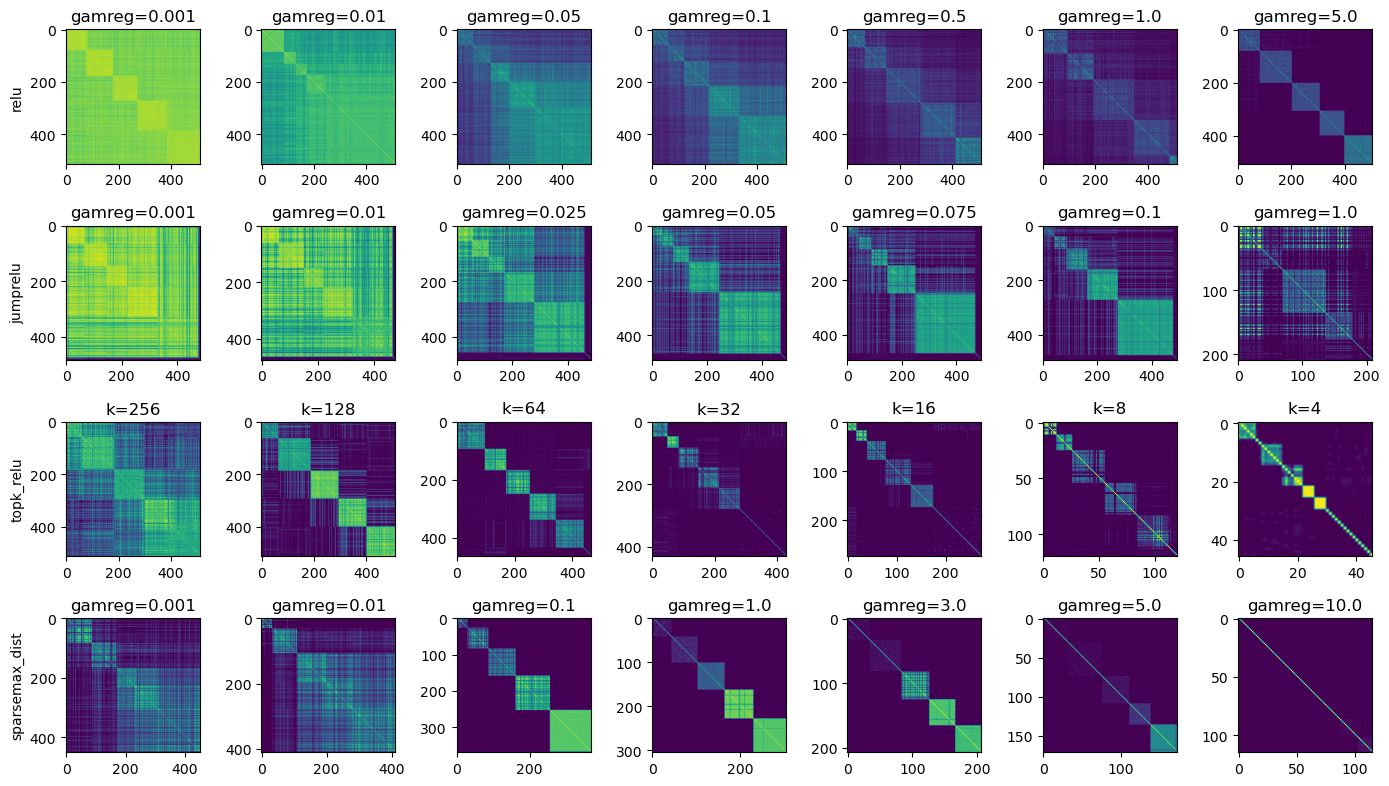

In [ ]:
#plot correlations between pairs of latents over all concepts
kvalues_order = [256, 128, 64, 32, 16, 8, 4]
fig, ax = plt.subplots(len(set(saetypes)), 7, figsize=(14, 8))
for i in range(len(exptnames)):
    if saetypes[i]!='topk_relu':
        if saetypes[i]=='relu':
            gammvals = gammavals_relu
        elif saetypes[i]=='jumprelu':
            gammvals = gammavals_jumprelu
        elif saetypes[i]=='sparsemax_dist':
            gammvals = gammavals_spade
        gami = float(exptnames[i].split('gamreg')[1].split('_')[0])
        loc = gammvals.index(gami)
    else:
        kvalues_oder = [256, 128, 64, 32, 16, 8, 4]
        kval_i = int(exptnames[i].split('topk_relu_k')[1].split('_')[0])
        loc = kvalues_order.index(kval_i)
    
    rowid = saeorder.index(saetypes[i])
    ax[rowid, loc].imshow(Clatent_cos_active[i].cpu(), cmap='viridis', vmin=0, vmax=1)
    # ax[rowid, loc].set_title(exptnames[i])
    if loc==0:
        ax[rowid, 0].set_ylabel(saetypes[i])
    # if rowid==0:
    if saetypes[i]=='topk_relu':
        ax[rowid, loc].set_title(f"k={kval_i}")
    else:
        ax[rowid, loc].set_title(f"gamreg={gami}")

fig.tight_layout()
fig.show()